In [19]:
import os
import numpy as np
import nibabel as nib
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.measurements import label

In [20]:
def load_segseg_model(model_seg_dir, weights_dir):
    json_file = open(model_seg_dir, 'r'); loaded_model_json = json_file.read(); json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights(weights_dir)
    return model

def normalize_image(img,low_p=0,up_p=100):
    """ Normalize image values to [0,1] """
    min_ = np.percentile(img.flatten(),low_p)
    max_ = np.percentile(img.flatten(),up_p)
    if min_ == max_ and max_ > 0:
        return (img - min_) / (max_ - min_)
    elif min_ == max_ and max_ == 0:
        return img
    else:
        new_img  = (img - min_) / (max_ - min_)
        new_img[new_img > 1] = 1
        new_img[new_img < 0] = 0

        return new_img
    
def process_mask(arr, out_shape):
    liv = arr[:,:,:,0]
    liv = zoom(liv, (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    liv[liv >= 0.5] = 1; liv[liv < 0.5] = 0
    liv = largestConnectedComponent(liv)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 10))
    for ii in range(arr.shape[-1]):
        arr_resize[:,:,:,ii] = zoom(arr[:,:,:,ii], (out_shape[0]/192, out_shape[1]/192, out_shape[2]/96))
    arr_resize[arr_resize <= 0.5] = 0.
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize[:,:,:,1:] ], -1), axis=-1)
    arr_resize = np.zeros((out_shape[0], out_shape[1], out_shape[2], 9))
    for ii in range(9):
        arr_resize[:,:,:,ii][np.where(arr == (ii+1))] = 1
        arr_resize[:,:,:,ii] = largestConnectedComponent(arr_resize[:,:,:,ii])
    arr = np.argmax(np.concatenate([ np.zeros((out_shape[0], out_shape[1], out_shape[2],1)), arr_resize ], -1), axis=-1)
    return liv,arr

def largestConnectedComponent(cnn_seg):
    cnn_seg[cnn_seg >= 0.5] = 1; cnn_seg[cnn_seg < 0.5] = 0
    struct = np.ones((3,3,3))
    pred_postp1 = cnn_seg
    labels, num_features = label(pred_postp1,struct)
    if num_features !=0:
        feature_size = np.zeros((num_features,))
        for ii in range(num_features):
            feature_size[ii] = np.sum(labels==(ii+1))
            label_liver = np.argmax(feature_size)
            pred_postp = np.zeros(cnn_seg.shape)
            pred_postp[labels== (label_liver+1)] = 1
    else:
        pred_postp = cnn_seg
    return pred_postp

In [3]:
model_dir = 'segmental_segmentation_model.hdf5' 
weight_dir = 'segmental_segmentation_weights.hdf5' 

model = load_segseg_model(model_dir, weight_dir)

In [5]:
mag_dir = r'N:\2_Analysis\automated_analysis\Flint_SOT_EOT_volume\nii files\FLINT_EOT_NII'
output = r'N:\2_Analysis\automated_analysis\Flint_SOT_EOT_volume\nii files\FLINT_EOT_WHOLE_LIVER_MASKS_NII'

In [45]:
for root, dirs, files in os.walk(mag_dir):
    for file in files:
        if file.endswith('.nii'):
            case_id = file[:6]
            
            echo0_ni = nib.load(os.path.join(root, file))
            echo0 = np.rot90(np.flip(echo0_ni.get_fdata(), 0))
            
            s0,s1,s2 = echo0.shape
            inp = zoom(echo0, (192/s0,192/s1,96/s2))
            inp = np.expand_dims(np.expand_dims(normalize_image(inp, 0, 95), 0), -1)

            pred = model.predict(inp)[0]

            liver,seg = process_mask(pred, echo0.shape)

            liver = np.swapaxes(liver,0,1)
            liver = np.rot90(np.flip(liver,0),3)
            liver = liver.astype('int8')
            
            img = nib.Nifti1Image(np.rot90(np.flip(liver, 0)), echo0_ni.affine)
            nib.save(img, os.path.join(output, case_id + '_EOT_whole_liver.nii'))

In [ ]:
# SINGLE PREDICTION

In [34]:
echo0_ni = nib.load(os.path.join(mag_dir, 'f_2422_EOT.nii'))
echo0 = np.rot90(np.flip(echo0_ni.get_fdata(), 0))
echo0.shape

(224, 224, 27)

<function matplotlib.pyplot.show(close=None, block=None)>

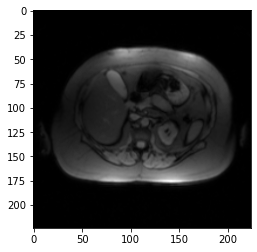

In [38]:
plt.imshow(echo0[:,:,10],cmap='gray')
plt.show

In [36]:
s0,s1,s2 = echo0.shape
inp = zoom(echo0, (192/s0,192/s1,96/s2))
inp = np.expand_dims(np.expand_dims(normalize_image(inp, 0, 95), 0), -1)

pred = model.predict(inp)[0]

liver,seg = process_mask(pred, echo0.shape)

liver = np.swapaxes(liver,0,1)
liver = np.rot90(np.flip(liver,0),3)
liver = liver.astype('int8')

<function matplotlib.pyplot.show(close=None, block=None)>

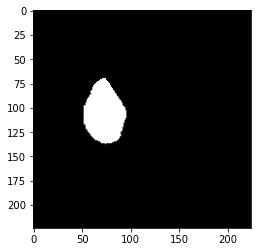

In [37]:
plt.imshow(liver[:,:,10],cmap='gray')
plt.show

In [42]:
img = nib.Nifti1Image(np.rot90(np.flip(liver, 0)), echo0_ni.affine)
nib.save(img, os.path.join(output, 'f_2422_EOT_whole_liver.nii'))